#### Interpretability methods
###### Packages

In [47]:
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Metric and model form scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
# Boosting model
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
# Tuning optimization
import optuna
import optuna.visualization as vis
# System utilities
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\maria\AppData\Local\Programs\Python\Python312\python.exe


#### The Dataset

In [48]:
df = pd.read_csv(r"Churn_clean.csv") # Data cleaning and feature engineering done in Feature_Engineering.ipynb
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID,log_Imp_Bonifici_vs_Competitors,log_Imp_Bonifici_vs_No_Competitors,log_Imp_Gestito_attuale,log_Num_Punti_Programma_Loyalty
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,2978.40,2980.92,0,0,0,0,NaN,2.909984,3.473983,NaN
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,NaN,34916.15,0,0,0,0,3.796631,2.918093,NaN,2.511883
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,NaN,232776.62,1,0,0,0,3.636488,3.032081,NaN,2.662758
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,15013.53,15017.53,0,0,0,0,NaN,NaN,4.176483,NaN
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,NaN,NaN,0,0,0,0,NaN,3.079181,NaN,3.562293


##### Preprocessing

In [60]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}).astype(int)
XX = pd.get_dummies(X) 

def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Split 4:5, random state to ensure reproducibility

XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False)) #Encoding of the categorical features
X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index] #division in train and test

# apply clean_feature_names
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train, X_test = X_train.align(X_test, join='inner', axis=1) #alignment of train and test columns, to ensure that they have the same lenght

X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

LightGBM 

In [78]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    "n_estimators": 297,
    "learning_rate": 0.010065762501114987,
    "max_depth": 13,
    "num_leaves": 25,
    "min_child_samples": 28,
    "subsample": 0.9186047768818155,
    "subsample_freq": 5,
    "colsample_bytree": 0.8969786318428297,
    "reg_alpha": 0.9097824682690728,
    "reg_lambda": 0.6075396766185748,
    "max_bin": 289,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_final, y_train_final)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]



AttributeError: 'LGBMClassifier' object has no attribute 'head'

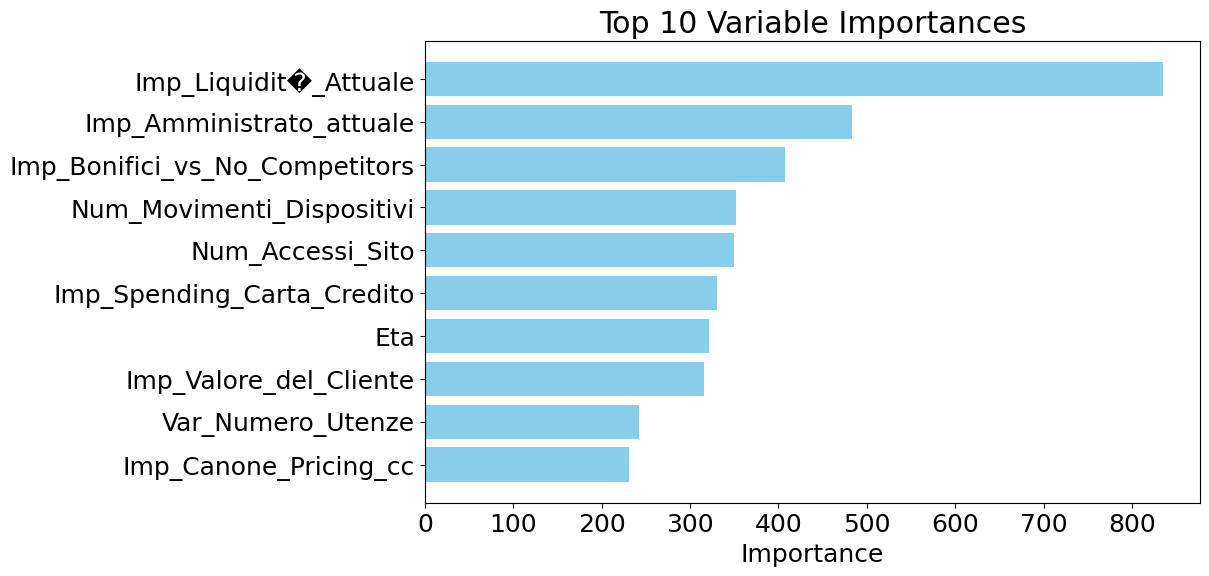

In [62]:
# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

In [92]:
import lime
from lime import lime_tabular

import pandas as pd

# Calcolare la media per le colonne numeriche
numeric_columns = X_train_final.select_dtypes(include=['float64', 'int64']).columns
X_train_final[numeric_columns] = X_train_final[numeric_columns].fillna(X_train_final[numeric_columns].mean())

# Calcolare la moda per le colonne categoriche
for column in categorical_columns:
    if X_train_final[column].isnull().any():
        mode_value = X_train_final[column].mode().iloc[0] if len(X_train_final[column].dropna()) > 0 else None
        if mode_value is not None:
            X_train_final[column] = X_train_final[column].fillna(mode_value)
            
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_final.values, 
                                                   feature_names=X_train_final.columns.values.tolist(),
                                                   class_names=['Flag_Richiesta_EStinzione_cc'], 
                                                   verbose=True, mode='classification')

In [93]:
X_train_final.head()

,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Anno_Apertura_primo_Conto,Imp_Reddito,Profilo_MIFID,Imp_Canone_Pricing_cc,Imp_Bonifici_vs_Competitors,Imp_Bonifici_vs_No_Competitors,...,Professione_Quadro,Professione_Rappresentante/Agente,Professione_Ufficiale/Sottoufficiale,Tipologia_Cliente_ActiveTrader,Tipologia_Cliente_Banker,Tipologia_Cliente_Investor,Tipologia_Cliente_Sleeper,Tipologia_Cliente_Trader,Sesso_F,Sesso_M
113915,16.61,1,0,22.0,2010.0,1.000000,2.0,0.0,3177.283157,334.000000,...,False,False,True,False,True,False,False,False,False,True
50421,192.73,0,0,82.0,2002.0,3.209353,4.0,0.0,3177.283157,1307.920000,...,False,False,False,False,False,True,False,False,True,False
291430,256.48,0,0,41.0,2001.0,5.000000,3.0,0.0,104.750000,2899.510000,...,True,False,False,False,True,False,False,False,False,True
193277,407.84,1,0,53.0,2006.0,3.209353,4.0,0.0,3177.283157,3352.041673,...,False,False,False,False,False,True,False,False,False,True
351658,2847.92,0,0,62.0,2008.0,3.209353,0.0,0.0,3177.283157,820.110000,...,False,False,False,False,True,False,False,False,False,True


In [94]:

exp = explainer.explain_instance(X_test_final.values[5], best_lgb_classifier.predict, num_features=6)
# Show the predictions
exp.show_in_notebook(show_table=True)

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16

XGBoost

In [31]:
import xgboost

# There was a problem with the parameters verbosity, I had to set manually a value in range in main xgboost configuration
xgb.set_config(verbosity=0)
config = xgb.get_config()
assert config['verbosity'] == 0
xgboost.config_context(verbosity=0)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb_params = {
    'n_estimators': 661,
    'learning_rate': 0.036491004518573594,
    'max_depth': 3,
    'min_child_weight': 4,
    'subsample': 0.6625916610133735,
    'colsample_bytree': 0.864803089169032,
    'gamma': 3.1877873567760657,
    'reg_alpha': 4.436063712881633,
    'reg_lambda': 4.7749277591032975,
    'scale_pos_weight': scale_pos_weight
}

best_xgb_classifier = xgb.XGBClassifier(verbosity=0, **xgb_params)
best_xgb_classifier.fit(X_train_final, y_train_final)
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]

Catboost

In [32]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

catboost_params = {
    'n_estimators': 486,
    'learning_rate': 0.08564115269968339,
    'max_depth': 5,
    'l2_leaf_reg': 5.495063193351241,
    'border_count': 113,
    'grow_policy': 'SymmetricTree',
    'min_data_in_leaf': 8,
    'leaf_estimation_iterations': 9,
    'leaf_estimation_method': 'Gradient',
    'scale_pos_weight': scale_pos_weight,
}

best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)

best_catboost_classifier.fit(X_train_final, y_train_final)
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]



0:	learn: 0.6659332	total: 55.5ms	remaining: 26.9s
1:	learn: 0.6436917	total: 97.5ms	remaining: 23.6s
2:	learn: 0.6227925	total: 138ms	remaining: 22.3s
3:	learn: 0.6047416	total: 181ms	remaining: 21.8s
4:	learn: 0.5896843	total: 220ms	remaining: 21.2s
5:	learn: 0.5758865	total: 262ms	remaining: 20.9s
6:	learn: 0.5628403	total: 306ms	remaining: 20.9s
7:	learn: 0.5519464	total: 347ms	remaining: 20.7s
8:	learn: 0.5409254	total: 389ms	remaining: 20.6s
9:	learn: 0.5320717	total: 433ms	remaining: 20.6s
10:	learn: 0.5246440	total: 475ms	remaining: 20.5s
11:	learn: 0.5176984	total: 516ms	remaining: 20.4s
12:	learn: 0.5128596	total: 555ms	remaining: 20.2s
13:	learn: 0.5065144	total: 595ms	remaining: 20.1s
14:	learn: 0.5015798	total: 636ms	remaining: 20s
15:	learn: 0.4967591	total: 675ms	remaining: 19.8s
16:	learn: 0.4919489	total: 718ms	remaining: 19.8s
17:	learn: 0.4865807	total: 760ms	remaining: 19.8s
18:	learn: 0.4827456	total: 801ms	remaining: 19.7s
19:	learn: 0.4793594	total: 843ms	remaini

Ensembling

In [33]:
# Manually set the weight
weight_catboost = 0.84
weight_xgb = 0.02
weight_lgbm = 0.16

In [34]:
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)